In [0]:
from google.colab import files
files.upload()
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c ieee-fraud-detection

The size of the data here is pretty big, so in order to handle it, there are some tricks that we can in order to save memory. This function does just that, by looking at the columns and sees is the minimum and maximum values can fit into int16, int32 or int64 or float16, float32 or float64.

In [0]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

First we import our dependencies in Python

In [0]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression

Now it is time to load the .csv files into memory. We do this we the pandas command read_csv and after loading them, we apply the defined reduce_mem_usage() function above to use as small of a int/float as possible. Please be aware - the function takes roughly 5 minutes to run.

In [87]:
%%time
train_identity = pd.read_csv('~/kaggle/fraud/train_identity.csv')
train_identity = reduce_mem_usage(train_identity)
test_identity = pd.read_csv('~/kaggle/fraud/test_identity.csv')
test_identity = reduce_mem_usage(test_identity)
train_transaction = pd.read_csv('~/kaggle/fraud/train_transaction.csv')
train_transaction = reduce_mem_usage(train_transaction)
test_transaction = pd.read_csv('~/kaggle/fraud/test_transaction.csv')
test_transaction = reduce_mem_usage(test_transaction)

Mem. usage decreased to 25.86 Mb (42.7% reduction)
Mem. usage decreased to 25.44 Mb (42.7% reduction)
Mem. usage decreased to 542.35 Mb (69.4% reduction)
Mem. usage decreased to 472.59 Mb (68.9% reduction)
CPU times: user 4min 33s, sys: 25.4 s, total: 4min 58s
Wall time: 4min 58s


We now look at the first 5 rows in the "identity" and the "transaction" dataframes to see how we can combine the two.

In [76]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
train_identity.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We see, that the "TransactionID" is present in both of the dataframes, so we combine the two dataframes on this ID.

In [88]:
%%time
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

CPU times: user 6.16 s, sys: 801 ms, total: 6.96 s
Wall time: 6.97 s


So now we have a train and a test dataframe to work on. 

# Does the type of device predict fraud?

We now do some exploration of the data. First we check if the number of frauds is different depending on the type of device the transaction originates from?

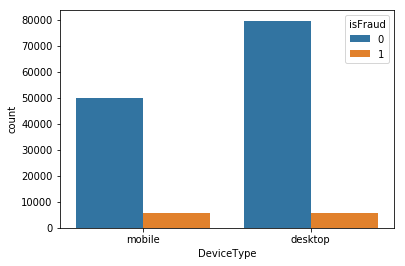

In [17]:
sns.countplot(train['DeviceType'], hue='isFraud', data=train);

Here we see, that the amount of fraud is pretty similar, which is what we can expect, since the 'DeviceType' can be faked, so it is no surprise, that there is no difference.

# Does the Time of Day predict fraud?

Maybe the time of day has something to do with if the transaction is fraud or not. 

The data has a 'TransactionDT' column, that we divide by the total number of seconds in a day. We then define 3600 bins which we put our data into, so that we get the plot below, that shows the difference in number of transactions per time.

Text(0, 0.5, 'Number of transactions')

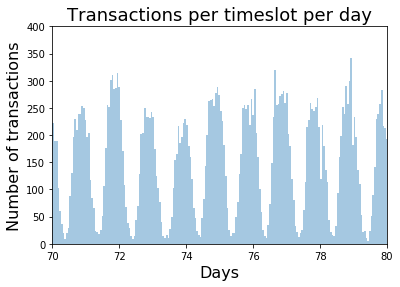

In [36]:
vals = sns.distplot(train['TransactionDT'] / (60*60*24),bins=3600, kde=False)
plt.xlim(70,80)
plt.ylim(0,400)
plt.title('Transactions per timeslot per day', fontsize=18)
plt.xlabel('Days', fontsize=16)
plt.ylabel('Number of transactions', fontsize=16)

As we can see the number of transactions fluctuates quite a bit. Does the same hold true for frauds as well? To answer this we need to divide the 'TransactionDT' into 24 chunks of 1 hour each and we add this new feature to the dataframe (the function is very broad, so the code can be reused in an other project, should a similar situation arise)

In [0]:
def make_hour_feature(df, tname='TransactionDT'):
    """
    Creates an hour of the day feature, encoded as 0-23. 
    
    Parameters:
    -----------
    df : pd.DataFrame
        df to manipulate.
    tname : str
        Name of the time column in df.
    """
    hours = df[tname] / (3600)        
    encoded_hours = np.floor(hours) % 24
    return encoded_hours

Now we can use our new function

Text(0, 0.5, 'Number of transactions')

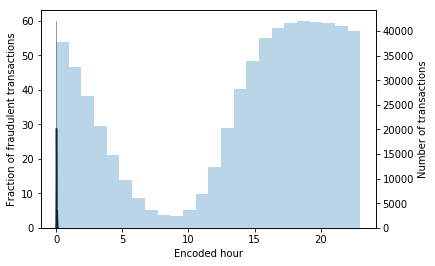

In [40]:
train['hours'] = make_hour_feature(train)


And now for some plotting :)

Text(0, 0.5, 'Number of transactions')

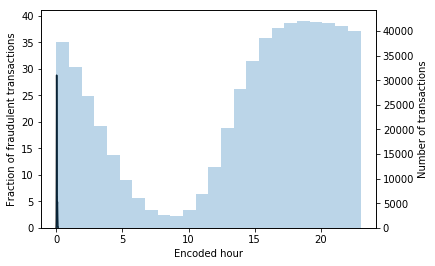

In [41]:
sns.distplot(train.groupby('hours').mean()['isFraud'], color='k')
ax = plt.gca()
ax2 = ax.twinx()
_ = ax2.hist(train['hours'], alpha=0.3, bins=24)
ax.set_xlabel('Encoded hour')
ax.set_ylabel('Fraction of fraudulent transactions')

ax2.set_ylabel('Number of transactions')

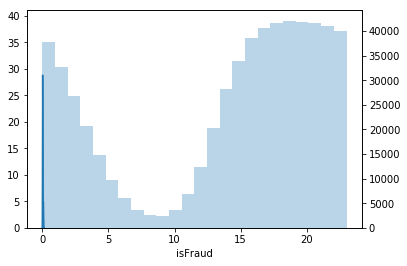

In [56]:
sns.distplot(train.groupby('hours')['isFraud'].mean());
ax = plt.gca()
ax2 = ax.twinx()
_ = ax2.hist(train['hours'], alpha=0.3, bins=24)


# How big is the fraud?

An other interesting thing is to see how big the fraud is and how big a percentage it is.

In [65]:
frauds = train.loc[train['isFraud'] == 1]
non_frauds = train.loc[train['isFraud'] == 0]

print(len(frauds))
print(len(non_frauds))

20663
569877


Next we plot the fraud on a scale to get an idea of how big the fraud amounts are for.

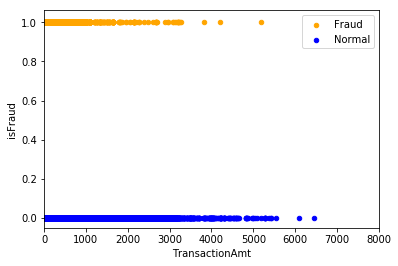

In [72]:
# Plot the fraud and non fraud based on the amount spent
ax = frauds.plot.scatter(x='TransactionAmt', y='isFraud', color='Orange', label='Fraud')
non_frauds.plot.scatter(x='TransactionAmt', y='isFraud', color='Blue', label='Normal', ax=ax)
plt.xlim(0,8000)
plt.show()


As we can see the fraud amounts are all pretty low - going up till about 6000.

# Model training

Now it is time for training the model itself. Here we "just" drop all the colums with at least 1 non-empty value. This will get updated in a later version of this colab, but this gives a quick benchmark.

In [0]:
train.dropna(axis='columns', inplace=True)

In [93]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
0,2987000,0,86400,68.5,W,13926,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0
1,2987001,0,86401,29.0,W,2755,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
2,2987002,0,86469,59.0,W,4663,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
3,2987003,0,86499,50.0,W,18132,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0
4,2987004,0,86506,50.0,H,4497,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0


In [0]:
y_train = train['isFraud'].copy()

In [0]:
X_train = train.drop('isFraud', axis=1)

In [0]:
"""For the features listed in the dataframe passed, train a logistic regression model, and report on the success of the model
Parameters:
    features     A list of strings that are the names of the features to inlucde in the training
    df           a dataframe of features
"""
def define_train_predict( features, df):
   # The target variable which we would like to predict, is the 'Class' variable
    target = 'Class'

    print("Features used in this analysis:")
    print( features )                        #just making sure it's really using the features passed

    # Now create an X variable (containing the features) and an y variable (containing only the target variable)
    X = df[features]
    y = df[target] 
    
    # Define the model
    model = LogisticRegression(solver = 'lbfgs' )


    # Define the splitter for splitting the data in a train set and a test set
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=0)

    
    for train_indices, test_indices in splitter.split(X, y):
        # Select the train and test data
        X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
        X_test, y_test = X.iloc[test_indices], y.iloc[test_indices]
    
        # Normalize the data
        X_train = normalize(X_train)
        X_test = normalize(X_test)
    
        # Fit and predict!
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
        # And finally: show the results
        print(classification_report(y_test, y_pred))

In [0]:
model = LogisticRegression(solver = 'lbfgs' )

In [102]:
model.fit(X_train, y_train)

ValueError: ignored

In [103]:
y_pred = model.predict(X_test)

NameError: ignored

In [0]:
print(classification_report(y_test, y_pred))